# `Poseidon-viewer` plot hydrographic stations demonstration

Extract temperature/salinity profiles at specified longitudes, latitudes, and times. This process mimics hydrographic stations from in-situ measurements (like a ship CTD station, or Argo float profile). The locations are easily imported to the notebook from the `Poseidon-viewer`.

This notebook:

* Demonstrates the interface to the `Poseidon-viewer` on SciServer
* Uses the [oceanspy](https://oceanspy.readthedocs.io/en/latest/) `subsample_stations` method to extract model data closest to the specified positions.
* Uses the [seaduck](https://macekuailv.github.io/seaduck/intro.html) `OceInterp` method to interpolate the model data to the specified positions.

See also the [`ECCO_plot_stations.ipynb` notebook](https://macekuailv.github.io/seaduck/sciserver_notebooks/ECCO_plot_stations.html) in the `seaduck` documentation.

Author: Tom Haine, Miguel Jimenez-Urias, Wenrui Jiang, Mitya Medvedev: Jul, Oct '23

In [1]:
import oceanspy as ospy
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 8

In [2]:
from dask.distributed import Client
client = Client()
client
import seaduck as sd

/home/idies/mambaforge/envs/Oceanography/lib/python3.10/contextlib.py:142: UserWarning: Creating scratch directories is taking a surprisingly long time. (1.00s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


### Pick the model dataset here. 

* `ECCO` is quick, coarse resolution, and good for initial exploration,
* `LLC4320` is slow, high resolution, and good for final figures.

See the [Poseidon datasets](https://www.poseidon-ocean.net/products/datasets/) for more details.

In [3]:
OGCM_dataset = 'ECCO'
# OGCM_dataset = 'LLC4320'

od = ospy.open_oceandataset.from_catalog(OGCM_dataset)

od._ds = od._ds.drop_vars({'k', 'k_u', 'k_p1', 'k_l'})
co_list = [var for var in od._ds.variables if "time" not in od._ds[var].dims]
od._ds = od._ds.set_coords(co_list)

if OGCM_dataset == 'LLC4320':
    this_time = '2012-04-28T00:00:00.000000000'     # Select time of interest. This is cut and pasted (with editing to convert format) from Poseidon-viewer, but in future should be returned in the JSON object.
elif OGCM_dataset == 'ECCO':
    od._ds = od._ds.drop_vars('time_bnds')
    od._ds['Temp'] = od._ds['THETA']
    od._ds['S'] = od._ds['SALT']
    this_time = '1992-03-16T12:00:00.000000000'     # Select time of interest. This is cut and pasted (with editing to convert format) from Poseidon-viewer, but in future should be returned in the JSON object.

varList = ['Temp', 'S']       # Select variables of interest.
Nvars = len(varList)
tmp_S = od._ds['S'].squeeze()
od._ds = od._ds.drop_vars([var for var in od._ds.data_vars if var not in varList]).where(tmp_S > 0.0)  # Drop unneeded variables and mask land.

Opening ECCO.
ECCO v4r4 3D dataset, ocean simulations on LLC90 grid (monthly mean output)


### Select the (longitude, latitude) coordinates of the stations required from the Poseidon Viewer

1. Use the Poseidon Viewer app to select the stations you want using the station select button:

<div>
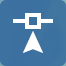
</div>

2. Mark the stations with the select button and save them via the save button:

<div>
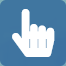
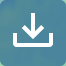
</div>

This method requires that the Poseidon Viewer is running in this SciServer container.

#### Or: 

2. Copy the stations from the Poseidon Viewer and paste them in the cell below via the copy to clipboard button:

<div>
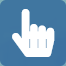
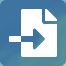
</div>

An example appears in the commented line below. This method works using the Poseidon Viewer app in the SciServer container, or in the standalone version.

The `oceanspy` `viewer_to_range()` function converts the JSON object from the Poseidon-viewer to a `list` that's ready for `oceanspy`.

In [4]:
from poseidon_viewer import get_shapes
import json, jmespath
# From the Poseidon-viewer save to disk function:
# shapes = json.loads(get_shapes())
# From the Poseidon-viewer save to clipboard function using paste:
shapes ={"type":"FeatureCollection","features":[{"type":"Feature","properties":{"timeFrom":"2012-04-25T00:00:00.000Z","timeTo":"2012-05-04T23:00:00.000Z"},"geometry":{"type":"Point","coordinates":[-71.00475883483884,38.36617979163577]}},{"type":"Feature","properties":{"timeFrom":"2012-04-25T00:00:00.000Z","timeTo":"2012-05-04T23:00:00.000Z"},"geometry":{"type":"Point","coordinates":[-65.54077720642087,37.88041890853975]}},{"type":"Feature","properties":{"timeFrom":"2012-04-25T00:00:00.000Z","timeTo":"2012-05-04T23:00:00.000Z"},"geometry":{"type":"Point","coordinates":[-63.98292446136473,33.798311038341666]}},{"type":"Feature","properties":{"timeFrom":"2012-04-25T00:00:00.000Z","timeTo":"2012-05-04T23:00:00.000Z"},"geometry":{"type":"Point","coordinates":[-70.08346939086911,30.311919887352303]}},{"type":"Feature","properties":{"timeFrom":"2012-04-25T00:00:00.000Z","timeTo":"2012-05-04T23:00:00.000Z"},"geometry":{"type":"Point","coordinates":[-76.54576492309567,31.36132181940374]}}]}

ps = jmespath.search('features[?geometry.type==\'Point\'].{type:geometry.type, coordinates:geometry.coordinates,timeFrom:properties.timeFrom,timeTo:properties.timeTo}', shapes)
this_time = ps[0]['timeFrom'][:-1]

### Create dataset with station data for the time of interest

The oceanspy `subsample.stations` method gives the model cell nearest the specified space coordinates.
Then the `sel(...,method = 'nearest')` call selects the timestep nearest to the specified time.

In [5]:
lons, lats = ospy.utils.viewer_to_range(ps)
stations_ds = od.subsample.stations(Ycoords=lats, Xcoords=lons)
stations_ds._ds = stations_ds._ds.sel(time = this_time,method = 'nearest')
Nstations = len(lons)

extracting Point
Extracting stations.


...and `seaduck.OceInterp` interpolates to the specified space-time coordinates.

In [6]:
tub = sd.OceData(od._ds)
times = sd.utils.convert_time(this_time)
Ntimes = times.size

depths = tub.Z.ravel()
Ndepths = len(depths)

sd_lons,sd_times,sd_depths = np.meshgrid(lons,times,depths,indexing='ij')
sd_lats,_,_ = np.meshgrid(lats,times,depths,indexing='ij')
sd_lons = np.ravel(sd_lons)
sd_lats = np.ravel(sd_lats)
sd_times = np.ravel(sd_times)
sd_depths = np.ravel(sd_depths)

[sd_Temp,sd_S] = np.array(sd.OceInterp(tub,varList, sd_lons, sd_lats, sd_depths, sd_times))
sd_depths2 = sd_depths.reshape(Nstations,Ntimes,Ndepths).squeeze()
sd_S = sd_S.reshape(Nstations,Ntimes,Ndepths).squeeze()
sd_Temp = sd_Temp.reshape(Nstations,Ntimes,Ndepths).squeeze()

sd_sigma0 = ospy.utils.densjmd95(sd_S,sd_Temp,0) - 1000.0

### Compute $\sigma_0$ seawater density anomaly for the extracted locations:

In [7]:
stations_ds._ds['sigma0'] = ospy.utils.densjmd95(stations_ds["S"],stations_ds["Temp"],0) - 1000.0
stations_ds._ds.sigma0.attrs['units'] = 'kg/m^3'
sd_sigma0 = ospy.utils.densjmd95(sd_S,sd_Temp,0) - 1000.0

### Plot station locations:

Cutting out the oceandataset.
faces in the cutout [10]


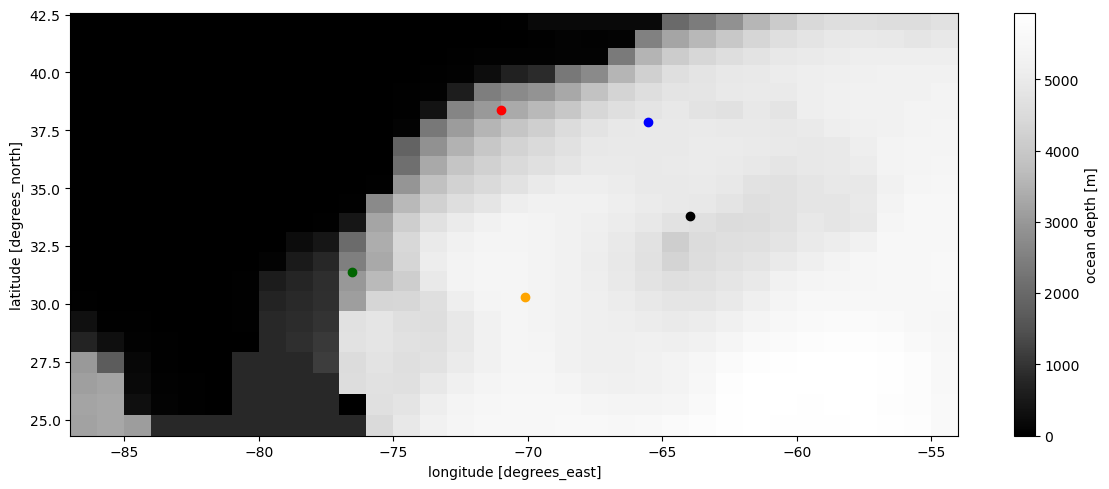

In [8]:
cut_od = od.subsample.cutout(XRange = [min(lons)-10,max(lons)+10],YRange = [min(lats)-5,max(lats)+5])
fig = plt.figure(figsize=(12, 5))
ax = cut_od.plot.horizontal_section(varName="Depth", cmap='Greys_r')
colors=['r', 'b', 'k', 'orange', 'darkgreen', 'm', 'yellow', 'c', 'indigo', 'magenta', 'green']
legestations_ds = np.arange(Nstations)
for i in range(Nstations):
    plt.plot(lons[i], lats[i], 'o', color=colors[i], label='station ' + str(legestations_ds[i]))
plt.show()

### Plot vertical T/S station profiles:

Dots show the interpolated `seaduck.OceInterp` values, lines show the nearest model grid cell values.

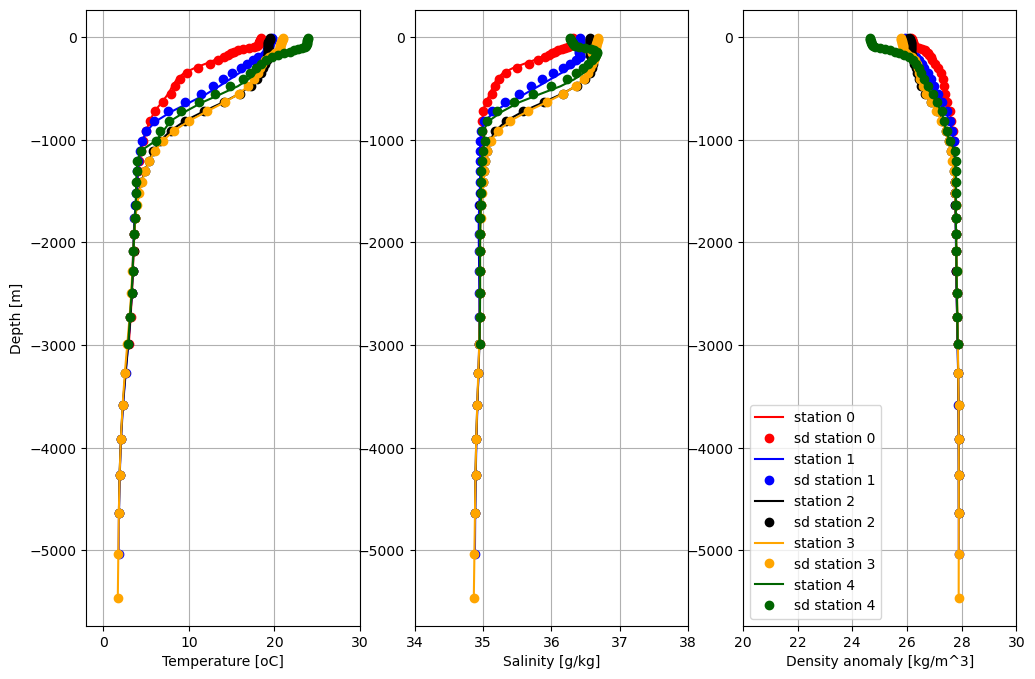

In [9]:
for i in range(Nstations):
    plt.subplot(1,3,1)
    plt.plot(stations_ds["Temp"].isel(station = i).squeeze(),stations_ds["Z"], color=colors[i], label='station ' + str(legestations_ds[i]))
    plt.plot(sd_Temp[i,:],depths,'o', color=colors[i], label='sd station ' + str(legestations_ds[i]))

    plt.subplot(1,3,2)
    plt.plot(stations_ds["S"].isel(station = i).squeeze(),stations_ds["Z"], color=colors[i], label='station ' + str(legestations_ds[i]))
    plt.plot(sd_S[i,:],depths,'o', color=colors[i], label='sd station ' + str(legestations_ds[i]))

    plt.subplot(1,3,3)
    plt.plot(stations_ds["sigma0"].isel(station = i).squeeze(),stations_ds["Z"], color=colors[i], label='station ' + str(legestations_ds[i]))
    plt.plot(sd_sigma0[i,:],depths,'o', color=colors[i], label='sd station ' + str(legestations_ds[i]))

plt.subplot(1, 3, 1)
plt.xlabel("Temperature [oC]")
plt.ylabel("Depth [m]")
plt.grid()
plt.xlim(-2,30)

plt.subplot(1, 3, 2)
plt.xlabel("Salinity [g/kg]")
plt.grid()
plt.xlim(34,38)

plt.subplot(1, 3, 3)
plt.xlabel("Density anomaly [kg/m^3]")
plt.grid()
plt.xlim(20,30)
plt.legend()
plt.show()

### Plot T/S diagram.

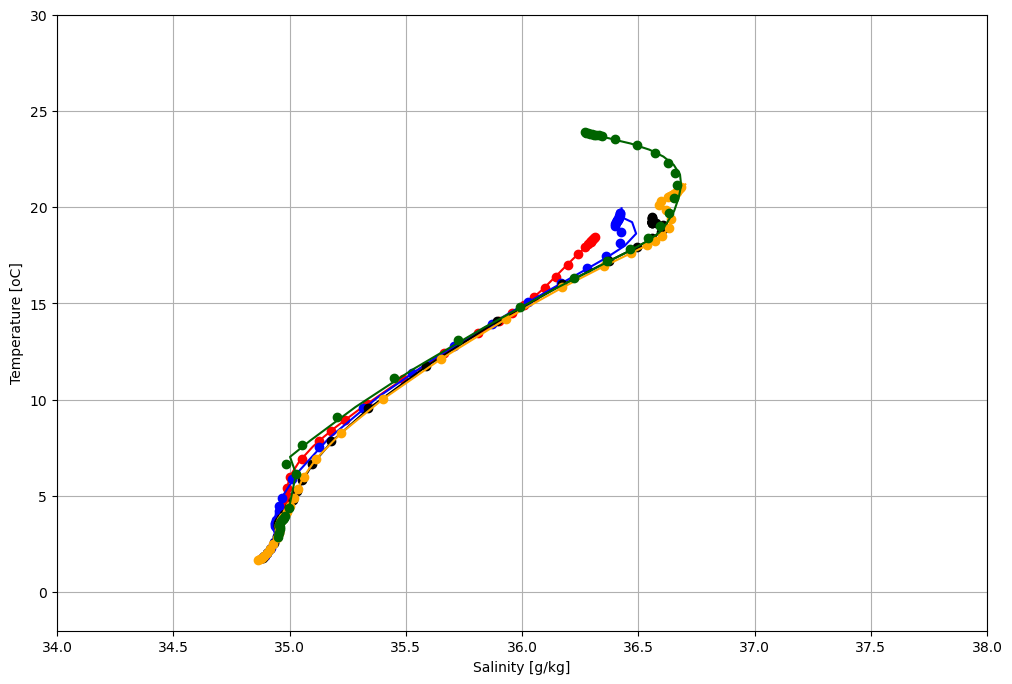

In [10]:
for i in range(Nstations):
    plt.plot(stations_ds["S"].isel(station = i).squeeze(),stations_ds["Temp"].isel(station = i).squeeze(), color=colors[i], label='station ' + str(legestations_ds[i]))
    plt.plot(sd_S[i,:],sd_Temp[i,:],'o', color=colors[i], label='sd station ' + str(legestations_ds[i]))
plt.grid()
plt.xlim(34,38)
plt.ylim(-2,30)
plt.xlabel("Salinity [g/kg]")
plt.ylabel("Temperature [oC]")
plt.show()